<a href="https://colab.research.google.com/github/Lotfullah21/Covolution/blob/main/Modified_U_Net_with_sobel_operator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [2]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 1.2 MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm

from keras.utils.np_utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers
from keras import backend as K

from sklearn.model_selection import train_test_split


In [29]:
path = './HGG1/'

In [47]:
def load_data(path):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  for p in tqdm(my_dir):
    data_list = sorted(os.listdir(path+p))
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])    
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    data.append([flair,t1,t1ce,t2])
    gt.append(seg)
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  return data, gt

In [52]:
data,gt = load_data(path)

100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


In [53]:
data = np.transpose(data,(0,2,3,4,1))

In [54]:
data = data[:,10:120,30:222,30:222,:].reshape([-1,192,192,4])   #taking 30-120 slices
gt = gt[:,10:120,30:222,30:222].reshape([-1,192,192,1])

In [55]:

import numpy as np
import matplotlib.pyplot as plt

from keras.utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers
from keras import backend as K

from skimage.segmentation import watershed


from sklearn.model_selection import train_test_split


In [56]:
wdata = np.zeros_like(data)

In [57]:
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 => one hot encoding

In [58]:
import cv2

def sobel(img):
  Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
  img_sobelx = cv2.Sobel(img, cv2.CV_8U,1,0,ksize=3)
  img_sobely = cv2.Sobel(img, cv2.CV_8U,0,1,ksize=3)
  img_sobel = img_sobelx + img_sobely+img
  return img_sobel


(-0.5, 191.5, 191.5, -0.5)

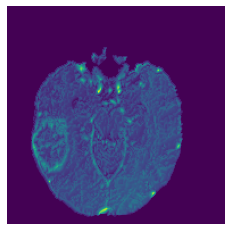

In [59]:
plt.imshow(sobel(data[40, :, :, 2]))
plt.axis("off")

In [60]:
for i in range(len(data)):
  for j in range(4):
    wdata[i,:,:,j] = sobel(data[i,:,:,j])

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(wdata, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [62]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [63]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((330, 192, 192, 4),
 (330, 192, 192, 4),
 (110, 192, 192, 4),
 (110, 192, 192, 4),
 (110, 192, 192, 4),
 (110, 192, 192, 1))

In [64]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((330, 192, 192, 4),
 (330, 192, 192, 4),
 (110, 192, 192, 4),
 (110, 192, 192, 4))

# UNet Model - With Additive Skip Connections


In [65]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [66]:
#encoder

inputs = Input(shape=(192,192,4),name='input')                                              

block0_conv1 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_norm1 = BatchNormalization(name='block0_batch_norm1')(block0_conv1)
block0_conv2 = Conv2D(32, 3,padding='same',activation='relu',name='block0_conv2')(block0_norm1)
block0_norm2 = BatchNormalization(name='block0_batch_norm2')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm2)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_norm1 = BatchNormalization(name='block1_batch_norm1')(block1_conv1)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_norm1)
block1_norm2 = BatchNormalization(name='block1_batch_norm2')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm2)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_norm1 = BatchNormalization(name='block2_batch_norm1')(block2_conv1)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_norm1)
block2_norm2 = BatchNormalization(name='block2_batch_norm2')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm2)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_norm1 = BatchNormalization(name='block3_batch_norm1')(block3_conv1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_norm1)
block3_norm2 = BatchNormalization(name='block3_batch_norm2')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm2)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_norm1 = BatchNormalization(name='block4_batch_norm1')(block4_conv1)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_norm1)
block4_norm2 = BatchNormalization(name='block4_batch_norm2')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm2)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm1, block4_norm2, up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm1, block3_norm2, up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm1, block2_norm2 ,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm1, block1_norm1, up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm1, block0_norm2 ,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

pre_output = Conv2D(32,1,padding = 'same',activation='relu',name='pre_output')(decod_block5_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 192, 192, 4  0           []                               
                                )]                                                                
                                                                                                  
 block0_conv1 (Conv2D)          (None, 192, 192, 32  1184        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 block0_batch_norm1 (BatchNorma  (None, 192, 192, 32  128        ['block0_conv1[0][0]']           
 lization)                      )                                                             

In [67]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.save_weights('weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[training_log,checkpointer],shuffle=True)

Epoch 1/30
42/42 [==============================] - 24s 248ms/step - loss: 0.6780 - dice_coef: 0.3220 - accuracy: 0.2091 - val_loss: 0.5971 - val_dice_coef: 0.4029 - val_accuracy: 0.2687
Epoch 2/30
42/42 [==============================] - 5s 118ms/step - loss: 0.5596 - dice_coef: 0.4404 - accuracy: 0.6076 - val_loss: 0.6022 - val_dice_coef: 0.3978 - val_accuracy: 0.1750
Epoch 3/30
42/42 [==============================] - 5s 115ms/step - loss: 0.3987 - dice_coef: 0.6013 - accuracy: 0.7316 - val_loss: 0.6012 - val_dice_coef: 0.3988 - val_accuracy: 0.2044
Epoch 4/30
42/42 [==============================] - 7s 172ms/step - loss: 0.2404 - dice_coef: 0.7596 - accuracy: 0.8674 - val_loss: 0.5959 - val_dice_coef: 0.4041 - val_accuracy: 0.2805
Epoch 5/30
42/42 [==============================] - 6s 141ms/step - loss: 0.0678 - dice_coef: 0.9322 - accuracy: 0.9648 - val_loss: 0.0725 - val_dice_coef: 0.9275 - val_accuracy: 0.9526
Epoch 6/30
42/42 [==============================] - 6s 139ms/step - l

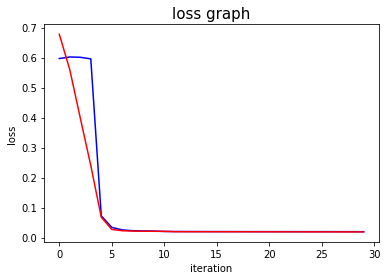

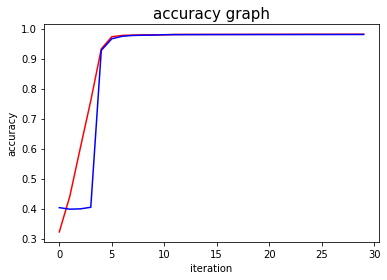

In [69]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()



In [70]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

4/4 [==============================] - 5s 636ms/step


In [71]:
np.unique(Y_pre)

array([0, 2])

In [72]:
Y_pre.shape

(110, 192, 192)

In [73]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [74]:
Y_test.shape,X_test.shape

((110, 192, 192, 1), (110, 192, 192, 4))

X_test 10


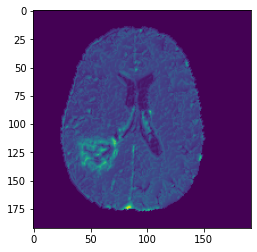

Predicted 10


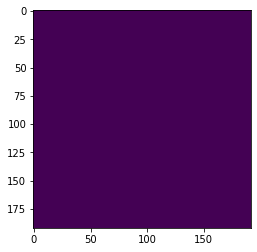

Actual 10


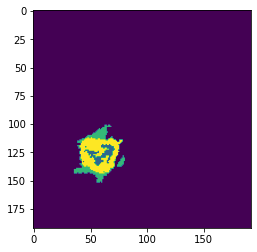

X_test 11


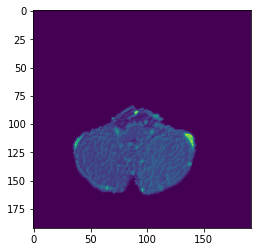

Predicted 11


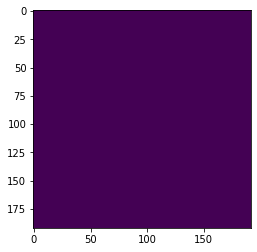

Actual 11


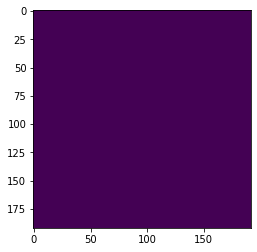

X_test 12


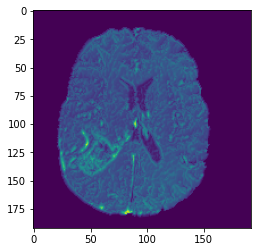

Predicted 12


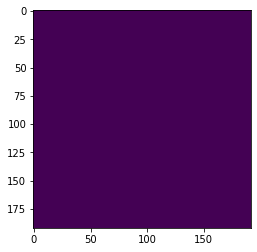

Actual 12


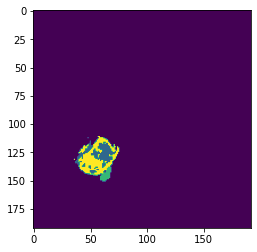

X_test 13


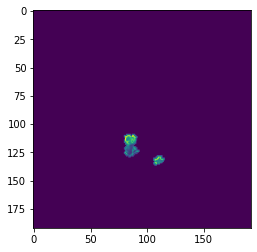

Predicted 13


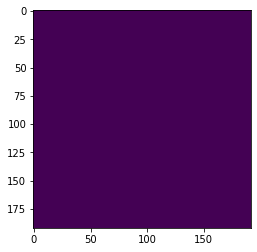

Actual 13


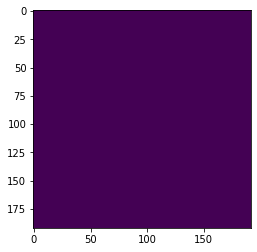

X_test 14


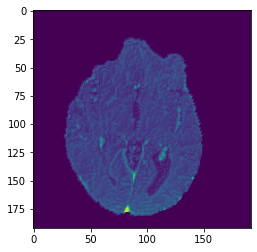

Predicted 14


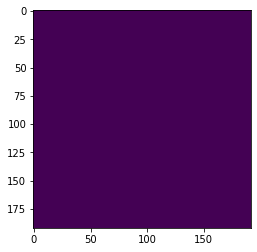

Actual 14


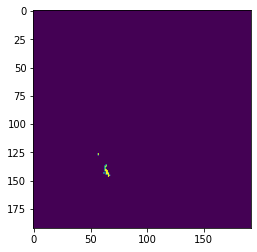

X_test 15


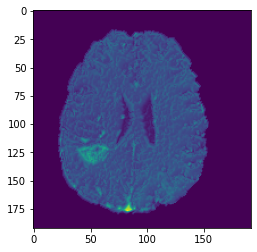

Predicted 15


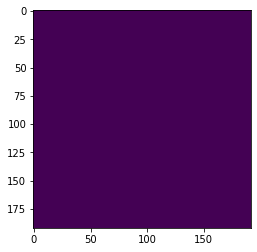

Actual 15


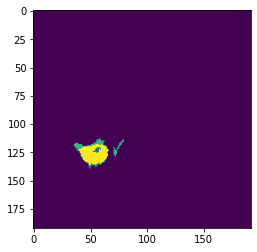

X_test 16


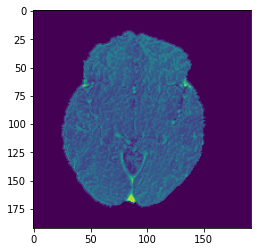

Predicted 16


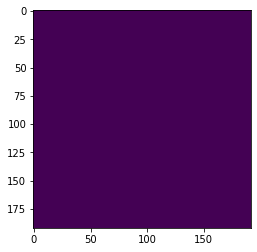

Actual 16


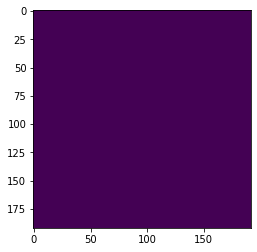

X_test 17


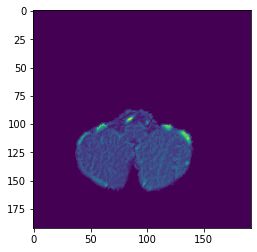

Predicted 17


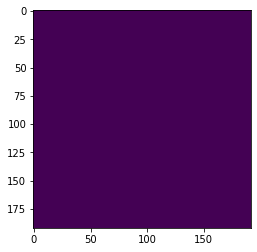

Actual 17


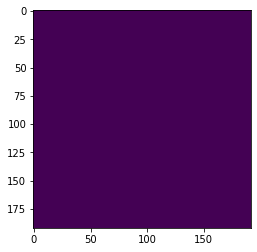

X_test 18


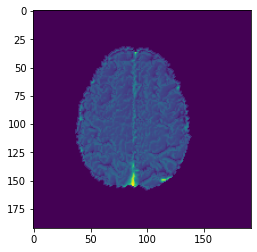

Predicted 18


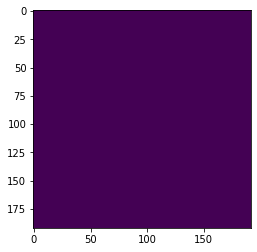

Actual 18


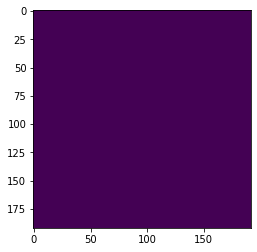

X_test 19


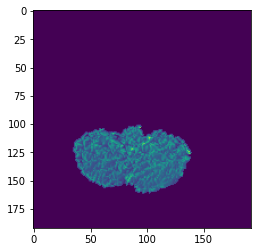

Predicted 19


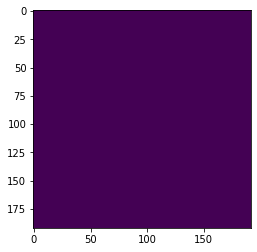

Actual 19


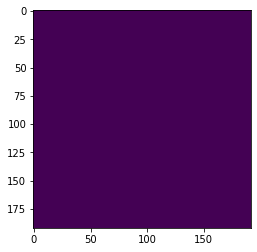

In [75]:
for i in range(10,20):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [76]:
Y_test_encod = to_categorical(Y_test)

In [77]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

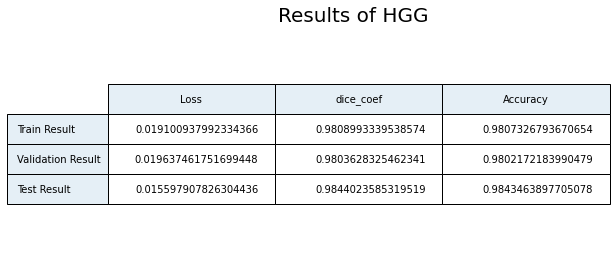

In [78]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

In [79]:
model.save("mod-unet-with-sobel.hdf5")